In [1]:
import os
import torch
import matplotlib.pyplot as plt
import random
import numpy as np
import re
import string
import gensim
import time
import itertools
import pickle
from torch.utils.data import DataLoader
from torch import nn
from sklearn.model_selection import KFold
import pandas as pd
import csv
from scipy.special import softmax
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(614)


In [2]:
# GPU
usingCuda = False
if torch.cuda.is_available():
    usingCuda = True
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
print('Using Cuda:', usingCuda)

Using Cuda: False


In [3]:
usingColab=True
if usingColab:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/My Drive/HW5_DeepLearning/'
else:
    path = ''

Mounted at /content/drive


In [4]:
titles = ["emma.txt", "pride_and_prejudice.txt", "mansfield_park.txt", "sense_and_sensibility.txt", "northanger_abbey.txt", "persuasion.txt"]

# Preprocessing on text:

- build one large text
- remove chapter headings (both "CHAPTER" and "Chapter")
- lowercase
- remove spurious newlines in text
- clear special symbols and numbers and sobstitute some of them
- sobstitute kept punctuation with words

In [5]:
def preprocess(input, load, filename='/text/austen.txt', is_seed=False):

    if load:

        austen = open(path+filename, 'r').read()
        print("Opened "+ str(filename))
        alphabet = list(set(austen))
        alphabet.sort()
        print('Found letters:', alphabet)
        return austen

    else:

        if is_seed:
            austen = input
        else:
            titles = input
            #building one single text
            texts_list=[open(path+"/text/"+text, 'r').read() for text in titles]
            austen = ""
            for text in texts_list:
                austen+=text

        #removing chapter headers
        austen = re.sub(r'CHAPTER.*\n+', '\n\n', austen)
        austen = re.sub(r'Chapter.*\n+', '\n\n', austen)

        #lowercase
        austen = austen.lower()

        #remove newlines inside text (no "true" newlines)
        austen = re.sub('(?<=[^.])\n'," ",austen)
        
        #sobstituting these characters with spaces
        odd_characters = ['"', '&', "'", '(', ')', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '[', ']', '_', '£', '—', '‘', '’', '“', '”']
        rx = '[' + re.escape(''.join(odd_characters)) + ']'
        austen = re.sub(rx, ' ', austen)

        #sobstituting some punctuation with "."
        punct_to_point = ['!', ':', ';']
        rx = '[' + re.escape(''.join(punct_to_point)) + ']'
        austen = re.sub(rx, '.', austen)

        #sobstituting accented vowels with "normal" version
        accented = ['à', 'é', 'ê']
        not_accented = ['a', 'e', 'e']
        for a, na in zip(accented, not_accented):
            austen = re.sub(a, na, austen)

        #sobstituting residual punctuation with words
        austen = re.sub('['+','+']', ' '+'commapunct'+' ', austen)
        austen = re.sub('['+'.'+']', ' '+'fullstoppunct'+' ', austen)
        austen = re.sub('['+'?'+']', ' '+'questpunct'+' ', austen)

        #remove multiple spaces
        austen = re.sub(' +', ' ', austen)

        alphabet = list(set(austen))
        alphabet.sort()
        print('Found letters:', alphabet)

        import codecs
        with codecs.open(path+filename, 'w', encoding="UTF-8") as F:
            F.write(austen)

        return austen

# Word Embedding and indexing

In [6]:
class MyDataset():
    def __init__(self, text, emb_dim=100, threshold=20, load=False):

        self.text = text
        self.sentences = self.get_sentences(threshold)
        self.embedding_w2v(emb_dim, load)

    def get_sentences(self, threshold):

        #Splitting in paragraphs. They alla end with a full stop and a newline. The output is a list of paragraphs
        paragraphs = re.split('fullstoppunct'+ ' ' + '\n', self.text)
        #Splitting each paragraph in its words
        paragraphs = [x.split() for x in paragraphs]
        #Paragraph is kept only if it is composed by more than "threshold" words! 
        # a quel punto per forza considero anche al punteggiatura
        paragraphs = [x for x in paragraphs if len(x) >= threshold]
        #the we separate each paragraph is as many sub-phrases as possible
        sentences=[]
        for par in paragraphs:
            start = 0
            end = start + threshold
            while end <= len(par):
                sentences.append(par[start:end])
                start +=threshold
                end +=threshold
        return sentences



    def embedding_w2v(self, emb_dim, load):

        if load:

            self.w2i = pickle.load(open(path+"/embedding_model/w2i.p", "rb"))  
            self.i2w = pickle.load(open(path+"/embedding_model/i2w.p", "rb"))
            self.w2s = pickle.load(open(path+"/embedding_model/w2s.p", "rb")) 

        else:

            start=time.time()
            embedding_model = gensim.models.Word2Vec(self.sentences, size=emb_dim, min_count=1, window=5, workers=4, iter=200)
            end=time.time()
            #saving model so tat it can be used again (see later for visualization)
            embedding_model.save(path+'/embedding_model/embedding_model.bin')
            print("Elapsed time for word embedding:", end-start)

            words = list(embedding_model.wv.vocab)
            self.w2i = {w: i for i, w in enumerate(embedding_model.wv.index2word)}      
            self.i2w = {embedding_model.wv.vocab[w].index : w for w in words}           
            
            #word 2 self to decode correctly punctuation
            self.w2s = {w : w for w in words}
            self.w2s['fullstoppunct'] = '.'
            self.w2s['commapunct'] = ','
            self.w2s['questpunct'] = '?'
            
            #saving embedding 
            torch.save(torch.FloatTensor(embedding_model.wv.vectors), f = path+"/embedding_model/embedding.torch")
            #saving w2i and i2w
            pickle.dump(self.w2i, open(path+"/embedding_model/w2i.p", "wb"))  
            pickle.dump(self.i2w, open(path+"/embedding_model/i2w.p", "wb"))  
            pickle.dump(self.w2s, open(path+"/embedding_model/w2s.p", "wb")) 

    def __len__(self):
        return len(self.sentences)
        

    def __getitem__(self, idx):
        text = self.sentences[idx]
        #encode
        encoded = encode(self.w2i,text)
        #sample contains both the sentence and its encoded version
        sample = {'text': text, 'encoded': encoded}
        return sample


def encode(dict_w2i, text):
    encoded = [dict_w2i[word] for word in text]
    return torch.LongTensor(encoded)

def decode(dict_i2w, numeric_text):
    decoded = [dict_i2w[num] for num in numeric_text]
    return decoded

## Visualization of embedding

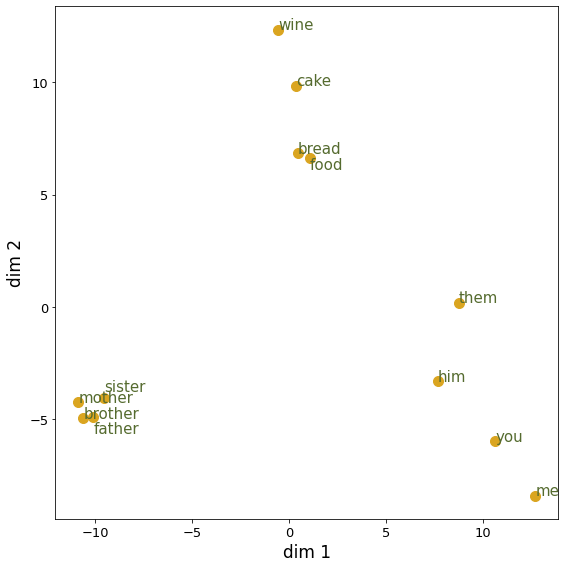

In [ ]:
from sklearn.decomposition import PCA
emb_model = gensim.models.Word2Vec.load(path+"/embedding_model/embedding_model.bin")
words=["mother", "father", "sister", "brother", "bread", "food", "cake", "wine",  "me", "you", "him", "them"]#,"tomorrow", "today", "yesterday",]
embedded = emb_model[words]
reduced = PCA(n_components = 2).fit_transform(embedded)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(reduced[:,0], reduced[:,1], color="goldenrod", s=100)
for i,word in enumerate(words):
    if word == "sister":
        ax.annotate(word, xy=(reduced[i,0], reduced[i,1]+0.3), color="darkolivegreen", fontsize=15)
    elif word == "food":
        ax.annotate(word, xy=(reduced[i,0], reduced[i,1]-0.5), color="darkolivegreen", fontsize=15)
    elif word == "father":
        ax.annotate(word, xy=(reduced[i,0], reduced[i,1]-0.7), color="darkolivegreen", fontsize=15)
    else:
        ax.annotate(word, xy=(reduced[i,0], reduced[i,1]), color="darkolivegreen", fontsize=15)    
ax.set_ylabel("dim 2", fontsize=17)
ax.set_xlabel("dim 1", fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.tick_params(axis='both', which='minor', labelsize=13)
fig.tight_layout()
fig.savefig(path+"/img/embedding_ex.png")

# Training

In [7]:
load_embedding = True
load_preprocessed = True
austen = preprocess(titles, load_preprocessed)
AustenDataset = MyDataset(austen, 100, 25, load_embedding)
print("\n\nINFORMATION ON THIS DATASET")
print("\n")
print("Number of sentences:", len(AustenDataset.sentences))
print("Number of unique words:", len(AustenDataset.w2i))
print("\n")

Opened /text/austen.txt
Found letters: ['\n', ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


INFORMATION ON THIS DATASET


Number of sentences: 30635
Number of unique words: 13316




In [8]:
#each train or test entry is a dictionary as in __getitem__
g =torch.cuda.manual_seed(614)
train, test = torch.utils.data.random_split(AustenDataset, [int(len(AustenDataset)*0.8),len(AustenDataset)-int(len(AustenDataset)*0.8)], generator=g)
print('Size of training set:',len(train))
print('Size of test set:',len(test))

Size of training set: 24508
Size of test set: 6127


In [9]:
class Network(nn.Module):
    def __init__(self, len_vocab, emb_dim, hidden_units, layers, dropout):
        super().__init__()

        #Creating pre-trained embedding layer at the beginning using the weight already computed
        embedding_matrix= torch.load(path+"embedding_model/embedding.torch")
        embedding_matrix = torch.FloatTensor(embedding_matrix)
        self.embedding = nn.Embedding(len_vocab, emb_dim).from_pretrained(embedding_matrix)
        self.embedding.weight.requires_grad=False   #pretrained

        self.rnn = nn.LSTM(input_size=emb_dim, 
                           hidden_size=hidden_units,
                           num_layers=layers,
                           dropout=dropout, 
                           batch_first=True)
        # Define output layer
        self.out = nn.Linear(hidden_units, len_vocab)
        
    def forward(self, x, state=None):
        #Embedding
        x = self.embedding(x)
        # LSTM
        x, rnn_state = self.rnn(x, state)
        # Linear layer
        x = F.leaky_relu(self.out(x))

        return x, rnn_state

    
    def train_epoch(self, dataloader, loss_fn, optimizer):
        # Training
        self.train()
        train_loss = []
        for batch_sample in dataloader:
            sample_batch = batch_sample['encoded']
            x = sample_batch[:, :-1].to(device) #all words besides the last
            y = sample_batch[:, 1:].to(device)  #all words besides the first one
            optimizer.zero_grad()
            predicted, _ = self.forward(x) #predicted has size (batchsize, 24, len_vocab)
            loss = loss_fn(predicted.transpose(1, 2), y) #transpose so that predicted and y match
            loss.backward()
            optimizer.step()
            train_loss.append(loss.data.cpu().numpy())
        return np.mean(np.array(train_loss))



    def test_epoch(self, test_dataloader, loss_fn):
        # Validation
        self.eval() # Evaluation mode (e.g. disable dropout)
        test_loss = []
        with torch.no_grad(): # No need to track the gradients
            for batch_sample in test_dataloader:
                sample_batch = batch_sample['encoded']
                x = sample_batch[:, :-1].to(device) #all words besides the last
                y = sample_batch[:, 1:].to(device)  #all words besides the first one
                predicted, _ = self.forward(x) #predicted has size (batchsize, 24, len_vocab)
                loss = loss_fn(predicted.transpose(1, 2), y) 
                test_loss.append(loss.data.cpu().numpy())
        return np.mean(np.array(test_loss))


    def train_full(self, epochs, patience, train_dataloader, val_dataloader, loss_fn, optimizer, verbose, filename):

        val_loss_best = float(1000)
        train_loss_log=[]
        val_loss_log=[]
        for epoch in range(epochs):

            start = time.time()

            train_loss = self.train_epoch(train_dataloader, loss_fn=loss_fn, optimizer=optim) 
            val_loss = self.test_epoch(val_dataloader, loss_fn=loss_fn) 

            end = time.time()

            #Print Validation loss

            if verbose:
                print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, epochs, val_loss))
                print("\n Time elapsed for one epoch:", end-start)

            if val_loss <= val_loss_best:
                # Save network parameters
                torch.save(self, path+filename)
                val_loss_best = val_loss
                waiting = 0
            else:
                waiting +=1

            #Early stopping
            if waiting >= patience and epoch > 20:
                return train_loss_log, val_loss_log
                print("Val loss has not improved for %d epochs ---> early stopping" %(patience))
                print("Best validation error was at epoch %d " %(epoch - patience))
                break

            train_loss_log.append(train_loss)
            val_loss_log.append(val_loss)
            torch.cuda.empty_cache()
            
        return train_loss_log, val_loss_log


    def predict(self, seed_text, text_length):

        clean_seed_text = preprocess(seed_text, load=False, filename="temp.txt", is_seed=True)
        clean_seed_text = clean_seed_text.split()
        w2i = pickle.load(open(path+"/embedding_model/w2i.p", "rb"))  
        i2w = pickle.load(open(path+"/embedding_model/i2w.p", "rb")) 
        w2s = pickle.load(open(path+"/embedding_model/w2s.p", "rb"))
        encoded = encode(w2i, clean_seed_text)
        encoded = encoded.unsqueeze(0).to(device)
        print(seed_text, end='', flush=True)

        #Creating context (needed to create first hidden state)
        self.eval() 
        with torch.no_grad():
            out, hstate = self(encoded)
            next = self.softmax_sampling(out[:, -1, :].cpu().numpy())
            decoded = i2w[next]
            print(w2s[decoded], end=' ', flush=True)
            encoded = torch.LongTensor([next])
            encoded = encoded.unsqueeze(0).to(device)
        for words in range(text_length-1):
            with torch.no_grad():
                out, hstate = self(encoded, hstate)
                next = self.softmax_sampling(out[:, -1, :].cpu().numpy())
                decoded = i2w[next]
                print(w2s[decoded], end=' ', flush=True)
                encoded = torch.LongTensor([next])
                encoded = encoded.unsqueeze(0).to(device)


    def softmax_sampling(self,x,return_prob=False):
        prob = softmax(x)
        vocab_idx = np.arange(prob.shape[1])
        prob = prob.reshape(-1,) #remove batch dim
        next_word = np.random.choice(vocab_idx, p=prob)
        if return_prob:
            return next_word.item(), prob
        return next_word.item()

## Grid serach with K-fold cross validation

In [ ]:

training = False
verbose = True

if training:

    #--------MODELS-----------------#
    pars = {"hidden_units" : [32, 64, 128, 256], "layers" : [2,3], "optimizer" : ['torch.optim.Adamax',"torch.optim.Adam"]}
    models = [dict(zip(pars.keys(), a)) for a in itertools.product(*pars.values())]

    #--------FIXED PARAMETERS-------#
    n_folds = 3
    patience = 10
    num_epochs = 120
    dropout = 0.3
    len_vocab = len(AustenDataset.i2w)
    emb_dim=100
    loss_fn = nn.CrossEntropyLoss()

    filename = path+"Models2.csv"
    parameters=["hidden_units", "layers", "optimizer", "val_loss"]
    list_of_models = pd.DataFrame(columns=parameters)
    list_of_models.to_csv(filename,index=False)

    # Split and train
    kfolds = KFold(n_splits=n_folds,random_state=0, shuffle=True)
    kfolds.get_n_splits(train)

    for nm, model in enumerate(models[10:]):

        print("\n\nTraining model:", nm)

        with open(filename,'a',newline='') as f:
            writer=csv.writer(f)

            #loop over folds
            CVlosses=[]
            cv_loop = 0

            for train_index, val_index in kfolds.split(train):

                print("\n\n\tTraining fold:", cv_loop)

                #reinitialize the network
                net = Network(len_vocab = len(AustenDataset.i2w), emb_dim=100, hidden_units=model["hidden_units"], layers=model["layers"], dropout=0.3)
                optim = eval(model["optimizer"])(filter(lambda p: p.requires_grad, net.parameters()),lr=1e-3, weight_decay=5e-4)
                net.to(device)

                ###divide validation and training set
                train_set = torch.utils.data.Subset(train, train_index)
                val_set = torch.utils.data.Subset(train, val_index)
                ### Define dataloader
                train_dataloader = DataLoader(train_set, batch_size=512, shuffle=True)
                val_dataloader = DataLoader(val_set, batch_size=512, shuffle=False)

                #Train for #epochs with early stopping
                tl, vl = net.train_full(num_epochs, patience, train_dataloader, val_dataloader, loss_fn=loss_fn, 
                                        optimizer=optim, verbose=verbose, filename="temp.torch")
                #load best model
                net = torch.load(path+"temp.torch")
                #compute validation loss over best model
                val_loss = net.test_epoch(val_dataloader, loss_fn)

                cv_loop +=1

                CVlosses.append(val_loss)

            #avg val loss for model
            CVloss = np.array(CVlosses).mean()
            model_dict={**model, "val_loss":CVloss}
            writer.writerow(list(model_dict.values()))
            f.close()  

else:

    print("Training flag is set to FALSE so no training was performed")

In [ ]:
filename=path+"Models.csv"
models = pd.read_csv(filename, sep=",").sort_values("val_loss")
pd.set_option('display.expand_frame_repr', False)
print(models)
best_set = models.iloc[[models.val_loss.argmin()]]
print("\n\nSet of best performing hyperparameters:")
print(best_set)
#save best set
best_set.to_csv(path+"best_set.csv", index=False)

    hidden_units  layers           optimizer  val_loss
13           256       2    torch.optim.Adam  4.866013
15           256       3    torch.optim.Adam  4.885771
12           256       2  torch.optim.Adamax  4.993549
14           256       3  torch.optim.Adamax  4.999260
9            128       2    torch.optim.Adam  5.099309
11           128       3    torch.optim.Adam  5.112176
8            128       2  torch.optim.Adamax  5.199933
10           128       3  torch.optim.Adamax  5.241249
5             64       2    torch.optim.Adam  5.305439
7             64       3    torch.optim.Adam  5.323928
4             64       2  torch.optim.Adamax  5.406657
6             64       3  torch.optim.Adamax  5.449478
1             32       2    torch.optim.Adam  5.516991
3             32       3    torch.optim.Adam  5.570031
0             32       2  torch.optim.Adamax  5.648295
2             32       3  torch.optim.Adamax  5.796940


Set of best performing hyperparameters:
    hidden_units  layer

## Final training

In [ ]:
final_train = False
verbose = True

if final_train:

    #Load best hyperparameters
    best_set=pd.read_csv(path+"best_set.csv", sep=",")
    best_set=best_set.drop(["val_loss"], axis=1).to_dict("r")[0]
    hidden_units = best_set["hidden_units"]
    optimizer = best_set["optimizer"]
    layers=best_set["layers"]
    
    #Rest of parameters
    n_folds = 3
    patience = 12
    num_epochs = 200
    dropout = 0.3
    len_vocab = len(AustenDataset.i2w)
    emb_dim=100
    loss_fn = nn.CrossEntropyLoss()

    
    #no cross validation is performed but a validation set is used for early stopping
    kfolds = KFold(n_splits=n_folds,random_state=0, shuffle=True)
    kfolds.get_n_splits(train)
    
        
    for train_index, val_index in kfolds.split(train):

        #reinitialize the network
        net = Network(len_vocab = len(AustenDataset.i2w), emb_dim=emb_dim, hidden_units=best_set["hidden_units"], layers=best_set["layers"], dropout=0.3)
        optim = eval(best_set["optimizer"])(filter(lambda p: p.requires_grad, net.parameters()),lr=1e-3, weight_decay=5e-4)
        net.to(device)

        ###divide validation and training set
        train_set = torch.utils.data.Subset(train, train_index)
        val_set = torch.utils.data.Subset(train, val_index)
        ### Define dataloader
        train_dataloader = DataLoader(train_set, batch_size=512, shuffle=True)
        val_dataloader = DataLoader(val_set, batch_size=512, shuffle=False)

        #Train for #epochs with early stopping
        tl, vl = net.train_full(num_epochs, patience, train_dataloader, val_dataloader, loss_fn=loss_fn, 
                                optimizer=optim, verbose=verbose, filename="Final_model.torch")
        #load best model
        net = torch.load(path+"Final_model.torch")
        test_dataloader = DataLoader(test, batch_size=512, shuffle=False)
        test_loss = net.test_epoch(test_dataloader, loss_fn)
        #we just train it over one fold
        break
        
    torch.save(net, path+'Final_model.torch')    
    print("Final model has test_loss:", test_loss.round(4))

else:
    
    print("Flag is set to FALSE, nothing happened")



	 VALIDATION - EPOCH 1/200 - loss: 6.372851



 Time elapsed for one epoch: 5.987667560577393


	 VALIDATION - EPOCH 2/200 - loss: 6.210822



 Time elapsed for one epoch: 5.938194990158081


	 VALIDATION - EPOCH 3/200 - loss: 6.176573



 Time elapsed for one epoch: 5.845213890075684


	 VALIDATION - EPOCH 4/200 - loss: 6.149204



 Time elapsed for one epoch: 5.84272837638855


	 VALIDATION - EPOCH 5/200 - loss: 6.073619



 Time elapsed for one epoch: 5.853593587875366


	 VALIDATION - EPOCH 6/200 - loss: 5.902969



 Time elapsed for one epoch: 5.871434211730957


	 VALIDATION - EPOCH 7/200 - loss: 5.711356



 Time elapsed for one epoch: 5.8600993156433105


	 VALIDATION - EPOCH 8/200 - loss: 5.551442



 Time elapsed for one epoch: 5.877165079116821


	 VALIDATION - EPOCH 9/200 - loss: 5.412802



 Time elapsed for one epoch: 5.980494260787964


	 VALIDATION - EPOCH 10/200 - loss: 5.311978



 Time elapsed for one epoch: 5.851618766784668


	 VALIDATION - EPOCH 11/200 - loss: 5

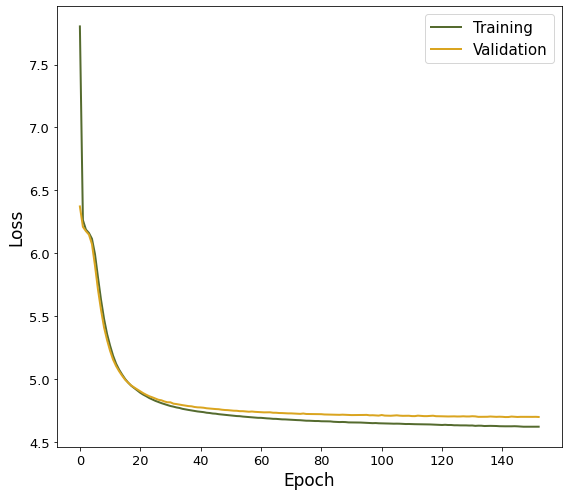

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,7))
ax.plot(tl, label="Training", color="darkolivegreen", linewidth=2)
ax.plot(vl, label="Validation", color="goldenrod", linewidth=2)
ax.set_ylabel("Loss", fontsize=17)
ax.set_xlabel("Epoch", fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.tick_params(axis='both', which='minor', labelsize=13)
ax.legend(fontsize=15)
fig.tight_layout()
fig.savefig(path+"img/final_training.png")
plt.show()

# Predict

In [15]:
net = torch.load(path+"Final_model.torch", map_location=torch.device('cpu'))
net.predict("one sunny morning she ", 30)

Found letters: [' ', 'e', 'g', 'h', 'i', 'm', 'n', 'o', 'r', 's', 'u', 'y']
one sunny morning she had been purchases to least . and was , though she now heat might forgot himself , these too , a information of the fascination aristocratic , back which body 